# MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape 

(70000,)

In [5]:
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt


## 数字画像を取り出す

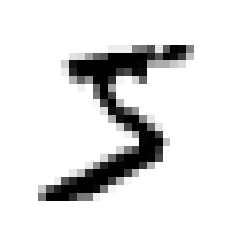

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
y[0]

'5'

In [8]:
type(y[0]) # 文字列は扱いにくい → 殆どのMLアルゴリズムでは数値を受け付けない → yの型を整数にキャストする必要がある

str

In [9]:
y = y.astype(np.uint8)

In [10]:
type(y[0])

numpy.uint8

In [11]:
y[0]

5

In [12]:
# 訓練データとテストデータにすでに別れているため、とりあえず変数に格納
# 訓練データはすでにシャッフル済み、交差検証のフォールドで同じ様なものになるため好都合

X_train, X_test, y_train, y_test = X[ : 60000], X[60000 : ], y[ : 60000], y[60000 : ]

# 二項分類器の訓練

## 5と5以外に分類するモデルを作成

In [13]:
# ターゲットベクトルを作成、5であればTrue
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier #モデルのインポート（確率的勾配降下法の分類器）

sgd_clf = SGDClassifier(random_state=42) # インスタンス作成
sgd_clf.fit(X_train, y_train_5) # モデル作成

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit]) 
# この分類器が5の画像を5と特定した → 実際にどれほどの予測精度があるのか測ってみる

array([ True])

# 性能指標
- 分類器の評価は回帰器よりも遥かに難しい
- 使われる性能指標は非常に多い
## 交差検証を使った正解率の測定

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [17]:
# cross_val_score関数みたいなものを自分で実装してみる

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 

#インスタンス生成
skfolds = StratifiedKFold(n_splits = 3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    # モデルのクローン作成
    clone_clf = clone(sgd_clf)
    # 分割した訓練データ
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    # 分割したテストデータ
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index] 
    # モデル作成
    clone_clf.fit(X_train_folds, y_train_folds)
    # 性能予測
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold) # モデルが正しく画像認識した数の合計
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


## すべての画像を「5以外」クラスに分類するダム分類器の結果を見てみる

In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier() # インスタンス生成
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

- この結果は、90%以上の正解率を示しているが、これは画像の約10%が5であるからに過ぎないためである。
- 故に、いつも５でないと予測していれば、約90%の正答率で当たるということだ。
- 今回は5と5以外が1:9の比で並んでいる
- このような歪んだデータセットの場合、正解率はモデルの性能指標として適当ではない
- 一般的に分類器の性能指標として正解率が好まれない

## 混同行列
- (a,b): aの画像をbと混同した回数
- (n,n)大　→　性能高
- テストセットは本番稼働に回せる分類器が完成しているプロジェクトの最後の段階だけで使う
- 混同行列を計算する方法として、実際のターゲットと比較できる「予測の集合」が必要になる
- テストセットを使い予測してもいいが、上記の事情により、テストセットは使えない。

In [20]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# sgd_clf：分類器モデル（SGDClassifier）
# cross_val_predict: 個々のテストフォールドに対する予測結果を返す

- cross_val_score→結果からスコアを返す　→　モデルが正しく画像認識した数をモデルが予測した数で割る
- cross_val_predict→個々のテストセット（検証セット？）を入力した時の予測結果そのものを返す

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
# y_train_5：ラベルの集合
# y_train_pred: 予測の集合

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
#仮に予測がすべて正しかった場合の混同行列の振る舞い
y_train_perfection_prediction = y_train_5  
confusion_matrix(y_train_5, y_train_perfection_prediction)

array([[54579,     0],
       [    0,  5421]])

## 適合率と再現率とF1値

In [28]:
from sklearn.metrics import precision_score, recall_score

In [29]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [30]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [31]:
from sklearn.metrics import f1_score

In [32]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### どの数値を評価指標として重視するべきか
- 子供に見せてはいけないビデオを検出するモデル
    - 実際に、多くの良いビデオを排除してしまっても、確実に安全なビデオだけを検出するモデルが好まれる
    - 言い換えると、適合率を高くして再現率を低くするのだ
- 監視カメラから万引き犯を見つけるモデル
    - 万引き犯であるのに万引き犯でないと予測してしまうケースを極力減らしたい
    - 言い換えると、再現率を高くして適合率を低くするのだ
- 再現率と適合率はトレードオフな関係のため、実際に両方とも値を高くすることは出来ないことは忘れてはならない